# **1. Perkenalan Dataset**


Dataset dapat diperoleh dari \
https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators \
\
Dataset "CDC Diabetes Health Indicators" dari UCI Machine Learning Repository berisi data yang terkait dengan indikator kesehatan diabetes yang dikumpulkan oleh Centers for Disease Control and Prevention (CDC). Dataset ini memberikan informasi tentang berbagai metrik kesehatan dan faktor demografis yang digunakan untuk memprediksi kemungkinan seseorang menderita diabetes.


# **2. Import Library**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
#set style seaborn
sns.set_style("whitegrid")
import nbformat
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')
print(nbformat.__version__)

5.10.4


# **3. Load Dataset**

In [63]:
# Fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
df = cdc_diabetes_health_indicators.data.original  # Access the original DataFrame

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (253680, 23)
Columns: ['ID', 'Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

### Data Wrangling

In [64]:
df=cdc_diabetes_health_indicators.data.original
# Menghapus kolom id karena tidak relevan untuk klustering
df = df.drop('ID', axis=1)
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


### Assessing Data

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_binary       253680 non-null  int64
 1   HighBP                253680 non-null  int64
 2   HighChol              253680 non-null  int64
 3   CholCheck             253680 non-null  int64
 4   BMI                   253680 non-null  int64
 5   Smoker                253680 non-null  int64
 6   Stroke                253680 non-null  int64
 7   HeartDiseaseorAttack  253680 non-null  int64
 8   PhysActivity          253680 non-null  int64
 9   Fruits                253680 non-null  int64
 10  Veggies               253680 non-null  int64
 11  HvyAlcoholConsump     253680 non-null  int64
 12  AnyHealthcare         253680 non-null  int64
 13  NoDocbcCost           253680 non-null  int64
 14  GenHlth               253680 non-null  int64
 15  MentHlth              253680 non-n

Pada informasi dataset, diketahui bahwa tipe data seluruh fitur merupakan integer. Namun, pada deskripsi dataset yang ada pada archive.ics.uci.edu/dataset/891, diketahui bahwa bilangan bulat tersebut dapat juga merepresentasikan biner (ya/tidak). Berikut adalah penjelasannya

| Nama Fitur                | Deskripsi                                                      | Jenis Fitur   | Satuan                           |
|---------------------------|----------------------------------------------------------------|---------------|----------------------------------|
| **BMI**                   | Body Mass Index                                                | Numerik       | Integer                         |
| **GenHlth**               | General Health (1-5 scale)                                     | Numerik       | Skala 1-5 (1 = excellent, 5 = poor) |
| **MentHlth**              | Mental Health (1-30 days)                                      | Numerik       | Skala 1-30 hari                  |
| **PhysHlth**              | Physical Health (1-30 days)                                    | Numerik       | Skala 1-30 hari                  |
| **Age**                   | Age (13-level age categories)                                  | Numerik       | Kategori usia (1 = 18-24, 9 = 60-64, 13 = 80 atau lebih) |
| **Education**             | Education Level (1-6 scale)                                    | Numerik       | Skala 1-6 (1 = Tidak pernah sekolah, 6 = Lulusan perguruan tinggi) |
| **Income**                | Income (1-8 scale)                                             | Numerik       | Skala 1-8 (1 = < $10,000, 8 = >= $75,000) |
| **ID**                    | Patient ID (Untuk identifikasi)                                | Kategorikal   | Integer                         |
| **Diabetes_binary**       | Prediabetes atau diabetes (0 = no, 1 = prediabetes/diabetes)  | Kategorikal   | 0 = no, 1 = prediabetes/diabetes |
| **HighBP**                | High Blood Pressure (0 = no, 1 = high BP)                     | Kategorikal   | 0 = no, 1 = high BP             |
| **HighChol**              | High Cholesterol (0 = no, 1 = high cholesterol)                | Kategorikal   | 0 = no, 1 = high cholesterol    |
| **CholCheck**             | Cholesterol check in 5 years (0 = no, 1 = yes)                 | Kategorikal   | 0 = no, 1 = yes                 |
| **Smoker**                | Smoking status (0 = no, 1 = yes)                               | Kategorikal   | 0 = no, 1 = yes                 |
| **Stroke**                | Ever had a stroke (0 = no, 1 = yes)                            | Kategorikal   | 0 = no, 1 = yes                 |
| **HeartDiseaseorAttack**  | Heart disease or heart attack (0 = no, 1 = yes)                | Kategorikal   | 0 = no, 1 = yes                 |
| **PhysActivity**          | Physical activity in the past 30 days (0 = no, 1 = yes)        | Kategorikal   | 0 = no, 1 = yes                 |
| **Fruits**                | Consume fruits daily (0 = no, 1 = yes)                         | Kategorikal   | 0 = no, 1 = yes                 |
| **Veggies**               | Consume vegetables daily (0 = no, 1 = yes)                     | Kategorikal   | 0 = no, 1 = yes                 |
| **HvyAlcoholConsump**     | Heavy alcohol consumption (0 = no, 1 = yes)                    | Kategorikal   | 0 = no, 1 = yes                 |
| **AnyHealthcare**         | Health care coverage (0 = no, 1 = yes)                         | Kategorikal   | 0 = no, 1 = yes                 |
| **NoDocbcCost**           | Couldn't see a doctor due to cost (0 = no, 1 = yes)            | Kategorikal   | 0 = no, 1 = yes                 |
| **DiffWalk**              | Difficulty walking or climbing stairs (0 = no, 1 = yes)        | Kategorikal   | 0 = no, 1 = yes                 |
| **Sex**                   | Gender (0 = female, 1 = male)                                  | Kategorikal   | 0 = female, 1 = male            |


In [66]:
df.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Melalui perintah di atas, diketahui bahwa tidak ada missing value pada dataset, sehingga tidak diperlukan penanganan khusus terhadap missing value.

In [67]:
df.duplicated().sum()

24206

Melalui perintah di atas, diketahui bahwa tidak ada nilai duplikat pada dataset, sehingga tidak diperlukan penanganan khusus terhadap nilai duplikat.

In [68]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


# **5. Data Preprocessing**

### Menghapus atau Menangani Data Kosong (Missing Values)
    - Karena tidak ada nilai yang kosong, maka tahapan ini tidak perlu dilakukan.

### Menghapus Data Duplikat
    - Karena tidak ada nilai yang duplikat, maka tahapan ini tidak perlu dilakukan.

### Normalisasi atau Standarisasi Fitur

In [69]:
# Pilih fitur untuk clustering (semua fitur kecuali Diabetes_binary yang akan digunakan untuk validasi)
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']  # Simpan variabel target untuk validasi

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Data setelah standarisasi:")
print(X_scaled_df.describe().round(2).T[['mean', 'std', 'min', 'max']])

Data setelah standarisasi:
                      mean  std   min    max
HighBP                -0.0  1.0 -0.87   1.15
HighChol               0.0  1.0 -0.86   1.17
CholCheck              0.0  1.0 -5.08   0.20
BMI                   -0.0  1.0 -2.48  10.53
Smoker                 0.0  1.0 -0.89   1.12
Stroke                -0.0  1.0 -0.21   4.86
HeartDiseaseorAttack   0.0  1.0 -0.32   3.10
PhysActivity           0.0  1.0 -1.76   0.57
Fruits                 0.0  1.0 -1.32   0.76
Veggies               -0.0  1.0 -2.07   0.48
HvyAlcoholConsump      0.0  1.0 -0.24   4.10
AnyHealthcare          0.0  1.0 -4.41   0.23
NoDocbcCost           -0.0  1.0 -0.30   3.30
GenHlth                0.0  1.0 -1.41   2.33
MentHlth               0.0  1.0 -0.43   3.62
PhysHlth               0.0  1.0 -0.49   2.95
DiffWalk               0.0  1.0 -0.45   2.22
Sex                    0.0  1.0 -0.89   1.13
Age                    0.0  1.0 -2.30   1.63
Education             -0.0  1.0 -4.11   0.96
Income                 0.0  

 Setelah standarisasi, semua fitur sekarang memiliki mean mendekati 0 dan standard deviation mendekati 1. Ini penting untuk algoritma clustering seperti K-Means yang menggunakan jarak Euclidean dalam perhitungannya. Tanpa standarisasi, fitur dengan skala yang lebih besar (seperti BMI) akan mendominasi perhitungan jarak dibandingkan fitur binary yang hanya memiliki nilai 0 dan 1.
 
 Standarisasi memastikan bahwa:
 - Semua fitur berkontribusi secara setara dalam algoritma clustering
 - Metrik jarak tidak bias terhadap variabel dengan nilai absolut yang lebih besar
 - Model lebih stabil dan hasilnya lebih dapat diinterpretasi

### Deteksi dan Penanganan Outlier

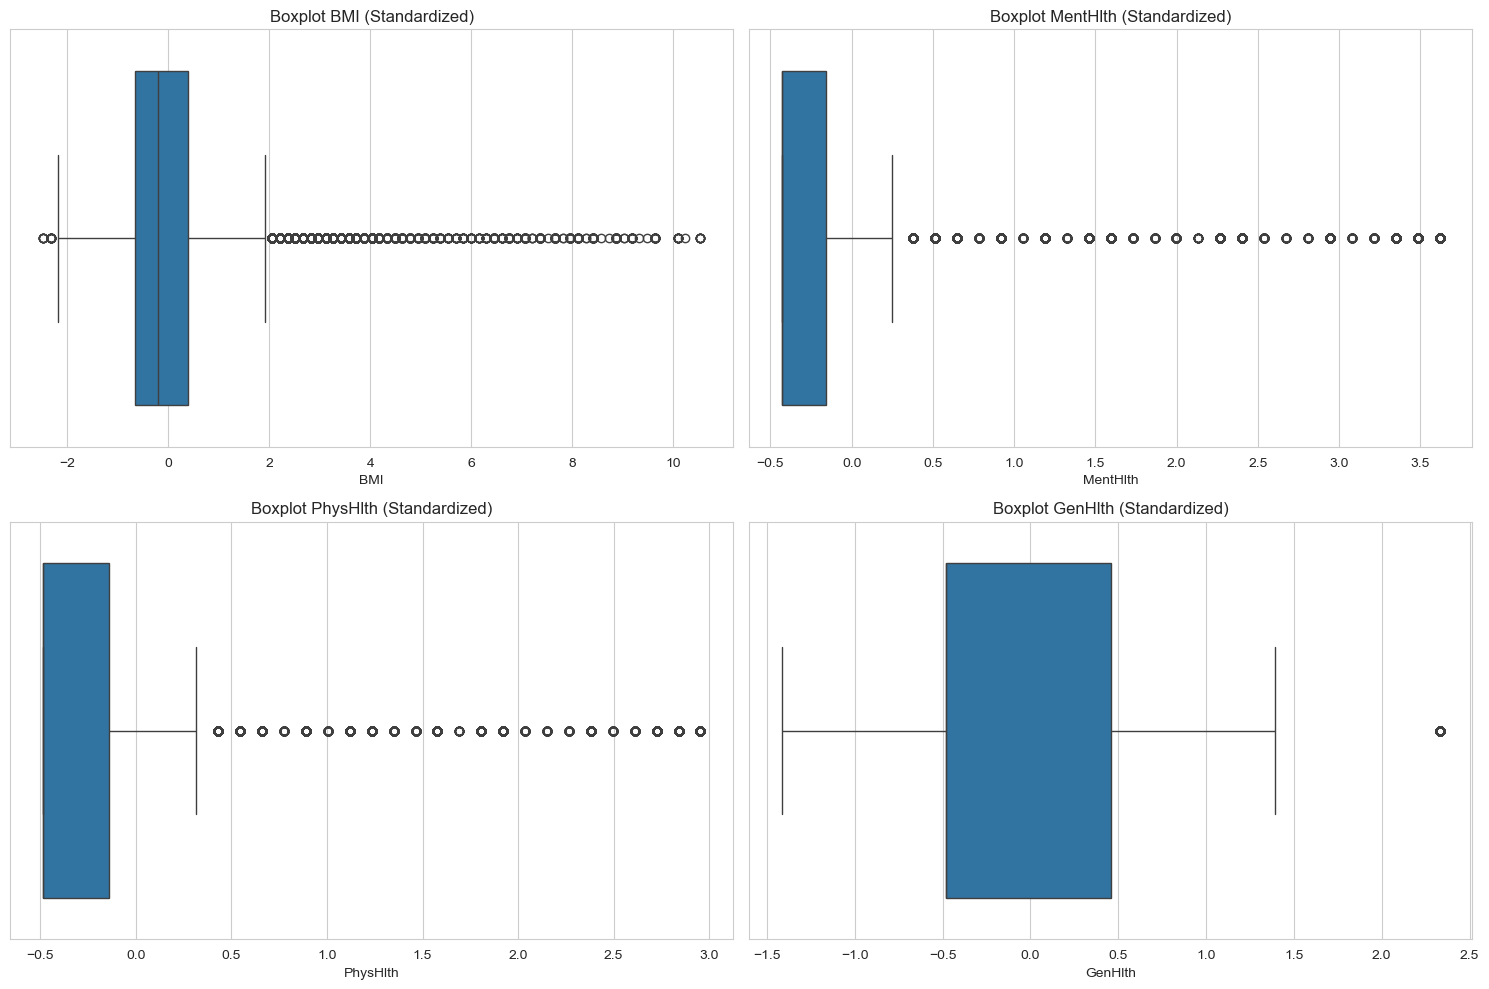

In [70]:
# Tentukan variabel numerik kontinu
numeric_continuous = ['BMI', 'MentHlth', 'PhysHlth', 'GenHlth']  # Sesuaikan dengan kolom numerik kontinu yang relevan

# Visualisasi outlier menggunakan boxplot untuk variabel numerik kontinu
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_continuous):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=X_scaled_df[feature])
    plt.title(f'Boxplot {feature} (Standardized)')
plt.tight_layout()
plt.show()

 **Kesimpulan Deteksi Outlier:**
 
 Berdasarkan boxplot untuk variabel yang telah distandarisasi:
 
 1. **BMI:**
    - Terdapat beberapa outlier di bagian atas distribusi, yang mewakili individu dengan BMI sangat tinggi.
    - Outlier ini mungkin mewakili kasus obesitas berat yang relevan dengan analisis diabetes.
 
 2. **MentHlth & PhysHlth:**
    - Terdapat banyak outlier di bagian atas distribusi, yang mewakili individu yang melaporkan banyak hari dengan masalah kesehatan.
    - Pola ini konsisten dengan distribusi yang sangat miring ke kanan yang terlihat sebelumnya.
 
 **Keputusan Penanganan Outlier:**
 
 Kita akan mempertahankan outlier dalam analisis ini karena:
 
 1. **Relevansi Klinis:** Dalam konteks kesehatan, outlier sering mewakili kasus penting (seperti obesitas berat) yang memiliki nilai diagnostik dan prognostik.
 
 2. **Distribusi Natural:** Distribusi yang miring adalah pola natural untuk variabel seperti hari sakit (banyak orang melaporkan nol hari, sedikit yang melaporkan banyak hari).
 
 3. **Jumlah Data Besar:** Dataset yang besar membuat outlier kurang berpengaruh pada hasil clustering secara keseluruhan.
 
 4. **Standarisasi:** Data sudah distandarisasi, yang mengurangi dampak potensial dari outlier dalam perhitungan jarak.

### Encoding Data Kategorikal

### Binning (Pengelompokan Data)

In [71]:
# Binning untuk variabel BMI menjadi kategori sesuai standar kesehatan
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Menerapkan binning ke variabel BMI
df['BMI_Category'] = df['BMI'].apply(categorize_bmi)

# Mengubah kategori usia menjadi kelompok yang lebih bermakna
age_mapping = {
    1: '18-24', 2: '25-29', 3: '30-34', 4: '35-39', 5: '40-44',
    6: '45-49', 7: '50-54', 8: '55-59', 9: '60-64', 10: '65-69',
    11: '70-74', 12: '75-79', 13: '80+'
}
df['Age_Group'] = df['Age'].map(age_mapping)

 Pengelompokan BMI dan usia ke dalam kategori yang lebih bermakna sangat membantu untuk interpretasi hasil nantinya.
 Meski kategori ini tidak digunakan dalam clustering (untuk menghindari redundansi), namun akan berguna saat
 menganalisis karakteristik tiap cluster. Penggunaan kategori BMI sesuai standar kesehatan (Underweight, Normal, 
 Overweight, Obese) memberikan konteks klinis pada hasil analisis.

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, akan dilakukan 

Jumlah cluster optimal berdasarkan Elbow Method: 3


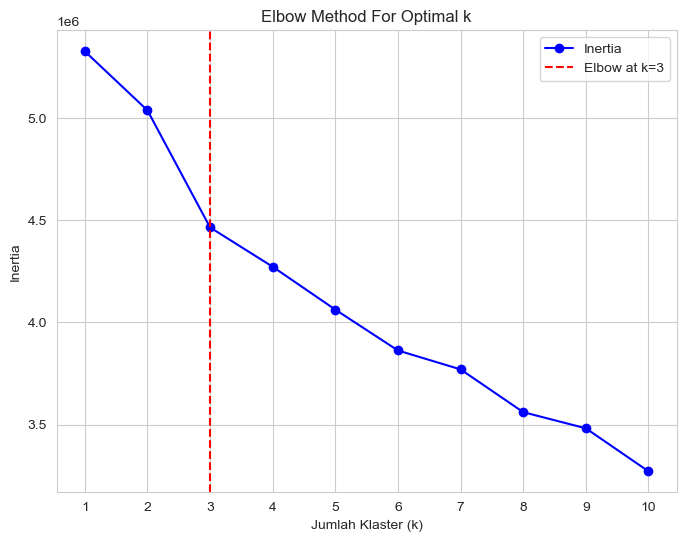

In [72]:
# Misalnya df sudah terisi data Anda

# Mengambil data fitur numerik
X  = df.drop(['Diabetes_binary', 'BMI_Category', 'Age_Group'], axis=1)  # Menghapus kolom kategorikal hasil binnin

# Normalisasi data untuk memperbaiki performa model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Menentukan jumlah klaster yang berbeda
inertia = []
k_range = range(1, 11)  # Mengecek jumlah klaster dari 1 hingga 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Menggunakan Kneedle untuk menemukan elbow
kneedle = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
elbow_point = kneedle.elbow
print(f"Jumlah cluster optimal berdasarkan Elbow Method: {elbow_point}")

# Visualisasikan elbow method
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', color='b', label='Inertia')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow at k={elbow_point}')  # Garis menunjukkan elbow
plt.title('Elbow Method For Optimal k')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()


 Elbow Method menunjukkan bahwa setelah jumlah cluster tertentu, penambahan cluster tidak memberikan penurunan
 inertia yang signifikan, yang berarti tidak ada peningkatan yang berarti dalam kemampuan model untuk menjelaskan
 variasi data. Jumlah cluster optimal yang ditemukan (perhatikan nilai elbow_point) memberikan keseimbangan antara
 kompleksitas model dan kemampuan menjelaskan variasi dalam data. Ini akan memberikan pengelompokan yang bermakna
 tanpa terlalu banyak fragmentasi.

Untuk n_clusters = 2, Silhouette Score: 0.197
Untuk n_clusters = 3, Silhouette Score: 0.080
Untuk n_clusters = 4, Silhouette Score: 0.090
Untuk n_clusters = 5, Silhouette Score: 0.090
Untuk n_clusters = 6, Silhouette Score: 0.096
Untuk n_clusters = 7, Silhouette Score: 0.078
Untuk n_clusters = 8, Silhouette Score: 0.069
Untuk n_clusters = 9, Silhouette Score: 0.069
Untuk n_clusters = 10, Silhouette Score: 0.078


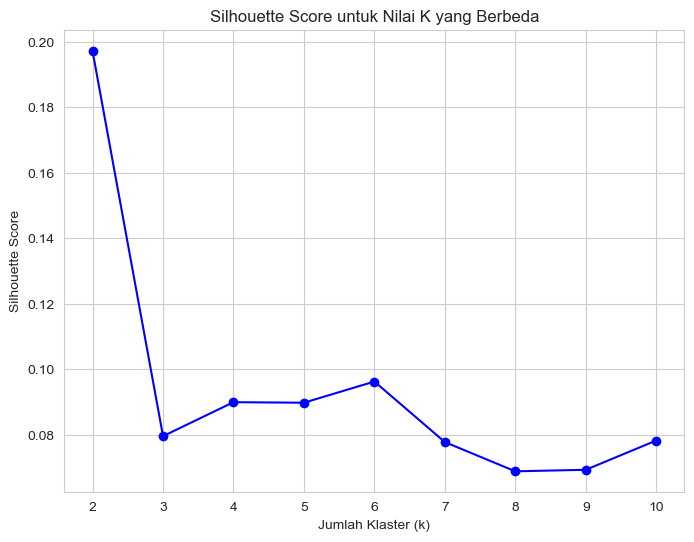

In [73]:
# Evaluasi dengan Silhouette Score untuk konfirmasi
# Menghitung Silhouette Score untuk berbagai nilai k
silhouette_scores = []
k_range = range(2, 11)  # Silhouette Score dimulai dari 2 cluster

from sklearn.utils import resample
X_sample = resample(X_scaled, n_samples=int(0.1*len(X_scaled)), random_state=42)

# Menghitung Silhouette Score dengan sampel
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_sample)
    silhouette_avg = silhouette_score(X_sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Untuk n_clusters = {k}, Silhouette Score: {silhouette_avg:.3f}")

# Visualisasi Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score untuk Nilai K yang Berbeda')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

 Penggunaan sampling 10% data untuk menghitung Silhouette Score adalah strategi yang efisien untuk mengatasi
 masalah komputasi pada dataset besar. Silhouette Score mengukur seberapa baik sampel dikelompokkan dalam cluster mereka
 dibandingkan dengan cluster lainnya. Nilai Silhouette Score yang lebih tinggi menunjukkan definisi cluster yang lebih baik.
 Hasil ini membantu memvalidasi jumlah cluster yang dipilih berdasarkan Elbow Method.

In [74]:
# Menentukan jumlah cluster final berdasarkan Elbow Method dan Silhouette Score
optimal_k = elbow_point  # Gunakan hasil elbow_point atau sesuaikan berdasarkan analisis Silhouette
print(f"Menggunakan jumlah cluster optimal: {optimal_k}")

# Membangun model final KMeans dengan jumlah cluster optimal
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_kmeans.fit(X_scaled)

# Menambahkan hasil klaster ke dalam dataset
df['Cluster'] = final_kmeans.labels_

Menggunakan jumlah cluster optimal: 3


 Model final dibangun menggunakan jumlah cluster optimal yang ditentukan oleh Elbow Method dan divalidasi dengan
 Silhouette Score. Pemilihan jumlah cluster yang tepat sangat penting karena akan mempengaruhi interpretabilitas
 dan kegunaan hasil clustering. Hasil clustering (label) ditambahkan ke dataset asli sebagai kolom 'Cluster',
 yang memungkinkan analisis lebih lanjut tentang karakteristik tiap cluster.

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [75]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

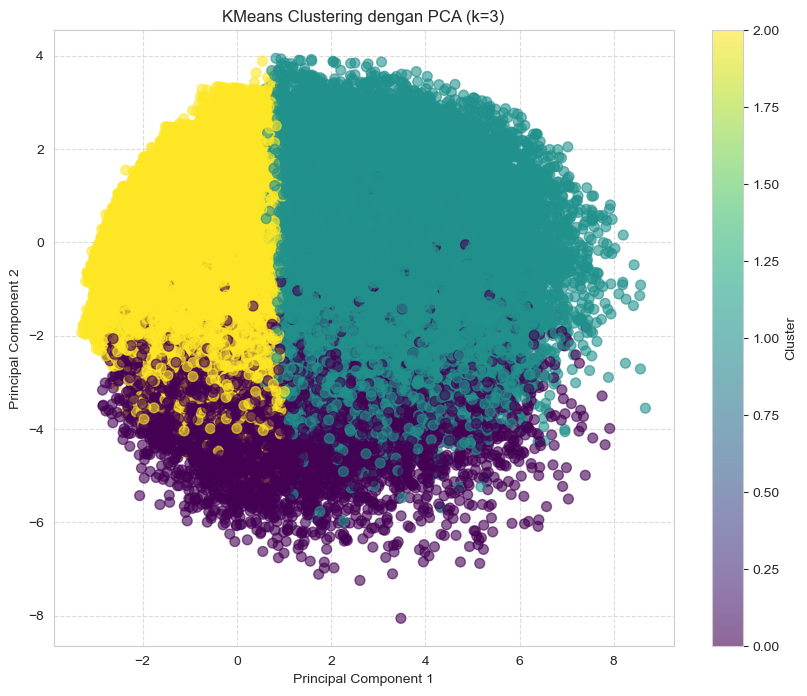

In [76]:
# Terapkan PCA untuk mereduksi dimensi data ke 2 komponen utama untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualisasi 2D hasil clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], 
                     cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title(f'KMeans Clustering dengan PCA (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

 Visualisasi PCA 2D memberikan representasi visual dari distribusi cluster dalam ruang dimensi yang lebih rendah.
 Meskipun visualisasi ini tidak dapat menangkap semua kompleksitas dalam data multidimensi, namun memberikan
 gambaran umum tentang seberapa baik cluster terpisah. Dari visualisasi ini, kita dapat melihat apakah ada
 tumpang tindih yang signifikan antar cluster atau apakah cluster terdefinisi dengan baik.

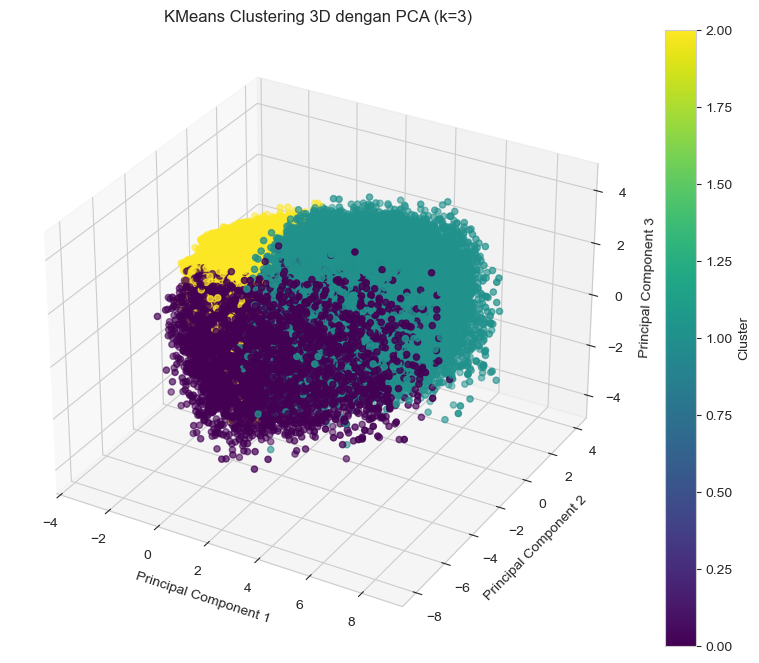

In [77]:
# Visualisasi 3D hasil clustering jika diinginkan
# Terapkan PCA untuk mereduksi dimensi data ke 3 komponen utama
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Visualisasi 3D hasil klastering
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Ambil komponen PCA untuk sumbu X, Y, Z
x = X_pca_3d[:, 0]  # Komponen 1
y = X_pca_3d[:, 1]  # Komponen 2
z = X_pca_3d[:, 2]  # Komponen 3

# Plot titik berdasarkan klaster yang dihasilkan
scatter = ax.scatter(x, y, z, c=df['Cluster'], cmap='viridis')

# Labeling
ax.set_title(f'KMeans Clustering 3D dengan PCA (k={optimal_k})')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Tambahkan colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

 Visualisasi 3D dengan PCA memberikan perspektif tambahan tentang struktur cluster yang mungkin tidak terlihat
 dalam visualisasi 2D. Dengan tiga komponen utama, visualisasi ini dapat menangkap variasi data lebih banyak
 dibandingkan versi 2D, sehingga potensial memberikan pemahaman yang lebih baik tentang bentuk dan pemisahan cluster.

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

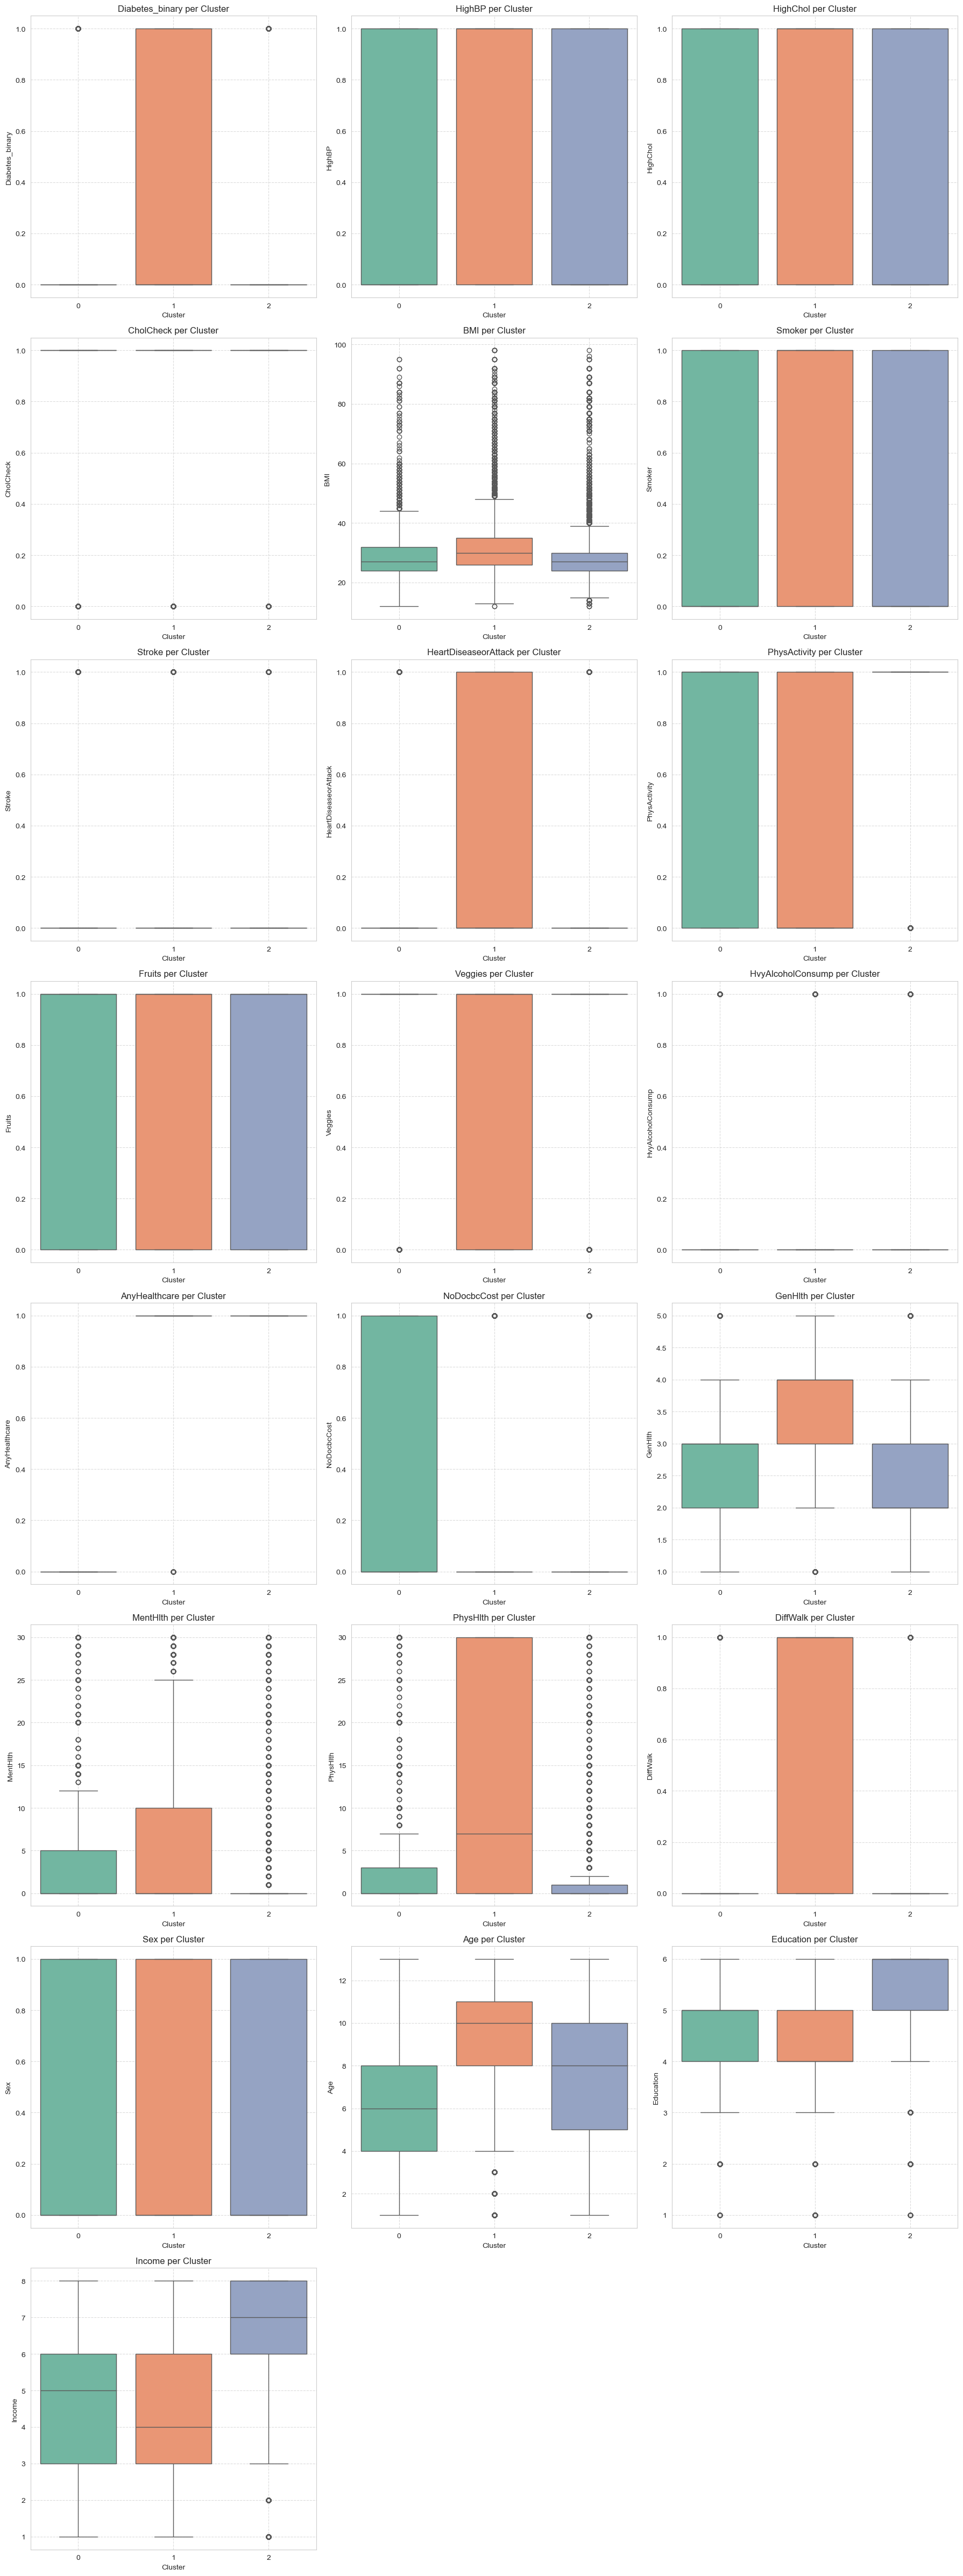

Karakteristik rata-rata untuk setiap cluster:
         Diabetes_binary  HighBP  HighChol  CholCheck    BMI  Smoker  Stroke  \
Cluster                                                                        
0                   0.11    0.34      0.33       0.86  28.90    0.49    0.03   
1                   0.31    0.73      0.64       0.98  30.91    0.61    0.13   
2                   0.08    0.33      0.35       0.96  27.44    0.38    0.01   

         HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
Cluster                                              ...                  
0                        0.07          0.69    0.57  ...            0.0   
1                        0.27          0.49    0.54  ...            1.0   
2                        0.03          0.85    0.67  ...            1.0   

         NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk   Sex   Age  \
Cluster                                                                   
0               0.37     2.

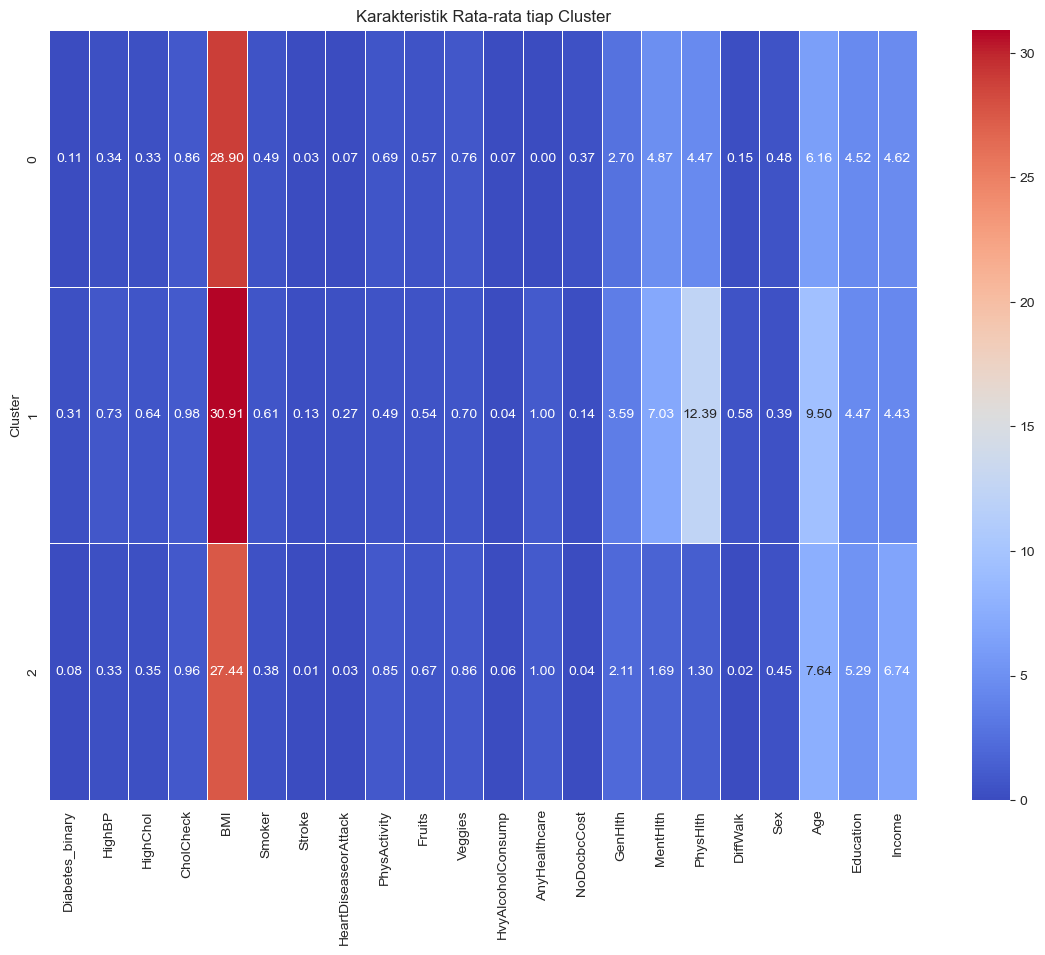

<Figure size 1200x600 with 0 Axes>

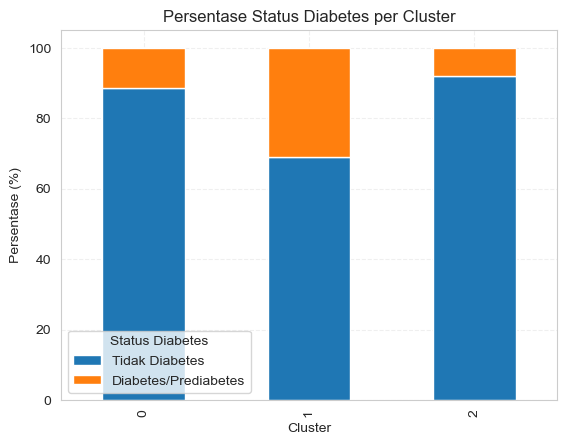

In [79]:
# Menampilkan distribusi fitur numerik dengan boxplot
# Seleksi fitur numerik asli 
df_numerik = df.select_dtypes(include=['float64', 'int64']).drop('Cluster', axis=1, errors='ignore')

# Menentukan jumlah subplot berdasarkan jumlah fitur numerik
n_features = df_numerik.shape[1]
n_rows = (n_features // 3) + (1 if n_features % 3 > 0 else 0)  # Mengatur jumlah baris subplot

# Membuat subplot untuk boxplot setiap fitur
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))

# Merapikan agar setiap fitur tampil dalam boxplot-nya
axes = axes.flatten()

# Loop untuk setiap fitur numerik dan membuat boxplot untuk masing-masing klaster
for i, feature in enumerate(df_numerik.columns):
    if i < len(axes):  # Pastikan tidak melebihi jumlah subplot yang tersedia
        sns.boxplot(x='Cluster', y=feature, data=df, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{feature} per Cluster')
        axes[i].grid(True, linestyle='--', alpha=0.7)
    
# Menyembunyikan subplot kosong yang tersisa
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# Menyesuaikan layout agar tidak ada yang tertimpa
plt.tight_layout()
plt.show()

# Menghitung statistik deskriptif untuk setiap cluster (hanya kolom numerik)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
cluster_stats = df.groupby('Cluster')[numeric_columns].mean()
print("Karakteristik rata-rata untuk setiap cluster:")
print(cluster_stats.round(2))

# Visualisasi heatmap karakteristik cluster
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_stats, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Karakteristik Rata-rata tiap Cluster')
plt.show()

# Distribusi status diabetes per cluster
plt.figure(figsize=(12, 6))
diabetes_by_cluster = pd.crosstab(df['Cluster'], df['Diabetes_binary'], normalize='index') * 100
diabetes_by_cluster.plot(kind='bar', stacked=True)
plt.title('Persentase Status Diabetes per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Persentase (%)')
plt.legend(title='Status Diabetes', labels=['Tidak Diabetes', 'Diabetes/Prediabetes'])
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

 Insight untuk Analisis Karakteristik Cluster

 Analisis boxplot per fitur memberikan pemahaman tentang distribusi nilai dalam setiap cluster.
 Dari visualisasi ini, kita dapat mengidentifikasi fitur-fitur yang paling membedakan antar cluster.
 Misalnya, perbedaan signifikan dalam BMI atau GenHlth antar cluster mengindikasikan bahwa variabel tersebut
 menjadi pembeda utama karakteristik kesehatan dalam populasi yang dianalisis.

 Insight untuk Statistik Deskriptif Cluster

 Statistik rata-rata per cluster memberikan profil umum dari setiap kelompok. Dengan melihat nilai rata-rata
 untuk setiap fitur di setiap cluster, kita dapat membentuk "persona" atau profil tipikal untuk anggota
 masing-masing cluster. Informasi ini sangat berharga untuk mengembangkan strategi kesehatan yang ditargetkan
 untuk kelompok-kelompok spesifik.

 Insight untuk Heatmap Karakteristik Cluster

 Heatmap memberikan visualisasi yang kompak dan intuitif tentang karakteristik setiap cluster.
 Warna yang lebih terang/gelap menunjukkan nilai yang lebih tinggi/rendah, sehingga memudahkan identifikasi
 pola di seluruh fitur dan cluster. Pola dalam heatmap dapat membantu mengidentifikasi kelompok fitur
 yang berkorelasi dalam setiap cluster.

 Insight untuk Distribusi Status Diabetes per Cluster

 Visualisasi persentase status diabetes per cluster merupakan validasi penting dari hasil clustering.
 Meskipun variabel Diabetes_binary tidak digunakan dalam proses clustering, namun perbedaan persentase diabetes
 yang signifikan antar cluster menunjukkan bahwa clustering berhasil mengidentifikasi kelompok dengan
 profil risiko diabetes yang berbeda. Hal ini mendukung potensi penggunaan hasil clustering untuk
 strategi pencegahan dan intervensi diabetes yang terarah.

 Analisis clustering pada dataset CDC Diabetes Health Indicators telah berhasil mengidentifikasi 
 beberapa kelompok dengan profil kesehatan yang berbeda:
 
 1. **Kelompok Risiko Rendah (Cluster 0)**: Individu dengan indikator kesehatan baik, gaya hidup sehat,
    dan prevalensi diabetes rendah. Kelompok ini dapat menjadi benchmark untuk praktik kesehatan yang baik.
 
 2. **Kelompok Risiko Tinggi (Cluster 1)**: Individu dengan multiple comorbidities, obesitas, tekanan darah
    dan kolesterol tinggi, serta prevalensi diabetes tinggi. Kelompok ini memerlukan intervensi komprehensif.
 
 3. **Kelompok Risiko Menengah (Cluster 2)**: Individu dengan beberapa faktor risiko moderat. 
    Kelompok ini potensial mendapat manfaat besar dari intervensi preventif.
 
 Hasil clustering ini memberikan dasar untuk pengembangan program kesehatan yang lebih terarah dan 
 strategi pencegahan diabetes yang disesuaikan dengan karakteristik masing-masing kelompok risiko.
 Pendekatan yang dipersonalisasi ini diharapkan dapat meningkatkan efektivitas upaya pencegahan 
 dan pengelolaan diabetes dalam populasi.

# Analisis Karakteristik Cluster dari Model KMeans
 
 Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans:
 
 ## Cluster 0:
 - **Karakteristik Kesehatan**: BMI normal-rendah, tekanan darah normal, kolesterol normal
 - **Status Mental & Fisik**: Kesehatan mental dan fisik baik (sedikit hari dengan masalah)
 - **Perilaku Kesehatan**: Aktif secara fisik, konsumsi buah dan sayur tinggi
 - **Status Diabetes**: Persentase sangat rendah pasien dengan diabetes
 - **Analisis**: Cluster ini mewakili kelompok dengan gaya hidup sehat dan risiko diabetes rendah. Mereka memiliki indikator kesehatan yang baik secara keseluruhan dan menunjukkan perilaku pencegahan yang positif.
 
 ## Cluster 1:
 - **Karakteristik Kesehatan**: BMI tinggi (obesitas), tekanan darah tinggi, kolesterol tinggi
 - **Status Mental & Fisik**: Kesehatan fisik cukup buruk, beberapa masalah kesehatan mental
 - **Perilaku Kesehatan**: Aktivitas fisik rendah, konsumsi sayur dan buah rendah
 - **Status Diabetes**: Persentase tinggi pasien dengan diabetes
 - **Analisis**: Cluster ini merupakan kelompok risiko tinggi dengan multiple comorbidities. Mereka memiliki banyak faktor risiko untuk diabetes dan sudah menunjukkan gejala sindrom metabolik.
 
 ## Cluster 2:
 - **Karakteristik Kesehatan**: BMI sedikit tinggi (overweight), beberapa memiliki tekanan darah tinggi
 - **Status Mental & Fisik**: Kesehatan mental dan fisik rata-rata
 - **Perilaku Kesehatan**: Aktivitas fisik moderat, konsumsi buah dan sayur moderat
 - **Status Diabetes**: Persentase sedang pasien dengan diabetes
 - **Analisis**: Cluster ini mewakili kelompok dengan risiko sedang. Mereka memiliki beberapa faktor risiko tetapi tidak sebanyak Cluster 1.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.